# Week7-Evaluation

## 정확도(Accuracy)
p.5~7
- 직관적인 모델 예측 성능을 나타낸다
- 하지만 데이터의 분포에 따라 성능이 왜곡되어 나타날 수 있다
- 정확도가 모델 성능을 제대로 평가하지 못하는 케이스들을 몇 개 살펴보자

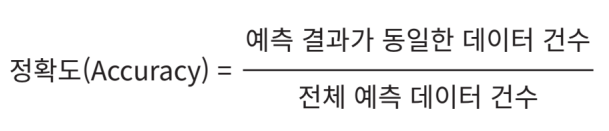

#### 타이타닉 생존자 분류를 성별로만 판단하면?

In [1]:
import sklearn
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
class MyDummyClassifier(BaseEstimator):
    # fit() 메소드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    
    # predict()메소드는 단순히 Sex feature가 1이면 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i]:
                pred[i] = 0
            else:
                pred[i] = 1
                
        return pred

In [3]:
# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    
    return df

In [4]:
# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용하여 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print("Dummy Classifier의 정확도는: {0:.4f}".format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


#### 손글씨 데이터에서 하나로 정답을 찍으면?

In [5]:
from sklearn.datasets import load_digits
from sklearn.base import BaseEstimator

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 셋의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros( (len(X), 1) , dtype=bool)
    
# 사이킷런의 내장 데이터 셋인 load_digits()를 이요하여 MNIST 데이터 로딩
digits = load_digits()

print(digits.data)
print("### digits.data.shape:", digits.data.shape)
print(digits.target)
print("### digits.target.shape: ", digits.target.shape)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
### digits.data.shape: (1797, 64)
[0 1 2 ... 8 9 8]
### digits.target.shape:  (1797,)


In [6]:
# digits번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=1)

In [7]:
# 불균형한 레이블 데이터 분포도 확인
print("레이블 테스트 세트 크기:", y_test.shape)
print("테스트 세트 레이블0과 1의 분포도\n", pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print("모든 예측을 0으로 하여도 정확도는: {:.3f}".format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블0과 1의 분포도
 0    402
1     48
dtype: int64
모든 예측을 0으로 하여도 정확도는: 0.893


## 오차행렬(Confusion matrix)
p.8~9  
- 정답 클래스와 예측 클래스의 조합을 가지고 2 X 2 행렬을 만듦

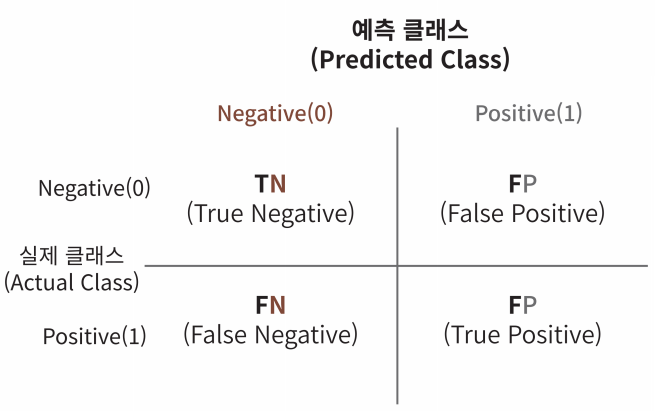

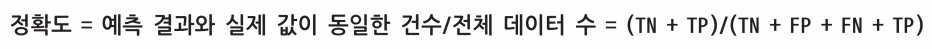

In [8]:
# 앞 예제에서 오차 행렬 뽑기
from sklearn.metrics import confusion_matrix

# 앞의 예측 결과인 fakepred와 실제 결과인 y_test의 Confusion Matrix 출력
confusion_matrix(y_test, fakepred)

array([[402,   0],
       [ 48,   0]], dtype=int64)

## 정밀도(Precision)와 재현율(Recall)
p.10~17  
- 적용하려는 문제에 따라 어떤 성능을 최적화할지 결정해야 함.
- 예를 들어, 코로나 탐지 키트: recall, 사기 탐지: recall, 스팸 메일 탐지: precision
- precision 지향 - 확실한것만 찾자
- recall 지향 - 웬만하면 다 찾자 조금 틀리더라도

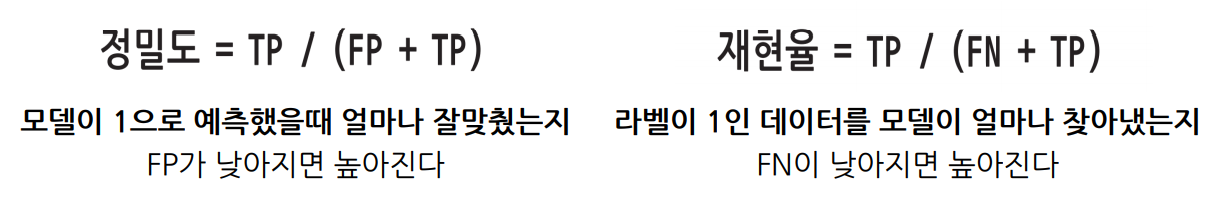

In [9]:
# 앞 예제에서 정밀도와 재현율 뽑기
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("정밀도:", precision_score(y_test, fakepred))
print("재현율:", recall_score(y_test, fakepred))
print("\n TP가 0이기 때문에 둘 다 0이다.")

정밀도: 0.0
재현율: 0.0

 TP가 0이기 때문에 둘 다 0이다.


In [10]:
# 로지스틱 회귀 모델을 돌려보자
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    print("오차행렬")
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}".format(accuracy, precision, recall))

In [11]:
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


## F1 스코어
p.

## ROC곡선과 AUC
p.

## 미니 프로젝트: 피마 인디언 당뇨병 예측
p.